# basic loading of an image in a net

- Dataset D
- création d'un AE sur ce dataset  (essayer de garder de quoi faire les déconvolutions)
    - l'AE prend des patch de 128*128*3 ou 256*256*3 en entrée et en sortie qui sont extraits et redimensionnés des images d'entrainements à différentes échelles et position (indépendants de la taille de l'image d'origine !!! Si il y a une grande image alors il y aura beaucoup de patchs)
- AE tronqué -> TNN
- TNN -> Partionnement de D en DLi (Domaines latents i€[1,N])
- entrainement d'une méthode légère sur tout le dataset (M0)
- finetuning de cette méthode M0 en MLi instances sur les DLi
- analyse des performances de l'oracle 
- comparaison à une création aléatoire des DLi (DAi) et d'un finetuning de MO en MAi


http://www.wolframalpha.com/



In [1]:
import getpass
import os
import sys

In [2]:
USER_NAME = getpass.getuser()
PATH_DATASETS = '/home/'+ USER_NAME +'/workspace/datasets/'
dataset_name = 'imagenet_sub'
path_train = PATH_DATASETS + dataset_name + '/train/'
path_test = PATH_DATASETS + dataset_name + '/test/'

CAFFE_ROOT = '/home/'+ USER_NAME +'/soft/caffe/'


In [3]:
PYTNN_ROOT = '/home/'+ USER_NAME +'/workspace/jg_tnn_py'
sys.path.insert(0, PYTNN_ROOT)
import pytnn

## Get infos one the selected dataset

In [4]:
classes = pytnn.getClasses(path_test, True)
paths_imgs = pytnn.getPaths(PATH_DATASETS,dataset_name,'train', True)
paths_imgs_byClass = pytnn.getPathsByClass(PATH_DATASETS,dataset_name, 'train', classes, True)

['chair', 'shelf', 'bike', 'person', 'table', 'keyboard', 'bag', 'screen', 'car', 'computer', 'phone']
imagenet_sub(train) contains 15150 images.
[imagenet_sub(train)] chair      : 1314 images.
[imagenet_sub(train)] shelf      : 1271 images.
[imagenet_sub(train)] bike       : 1210 images.
[imagenet_sub(train)] person     : 1118 images.
[imagenet_sub(train)] table      : 1751 images.
[imagenet_sub(train)] keyboard   : 2003 images.
[imagenet_sub(train)] bag        : 1151 images.
[imagenet_sub(train)] screen     : 1368 images.
[imagenet_sub(train)] car        : 1177 images.
[imagenet_sub(train)] computer   : 1598 images.
[imagenet_sub(train)] phone      : 1189 images.


## Produce patches (views) of one image

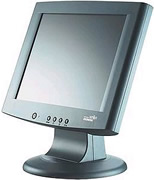

In [5]:
from io import BytesIO
import numpy as np
import PIL
from IPython.display import Image

## caffe cat
#num_patch_example = -1
#path_img = CAFFE_ROOT+'examples/images/cat.jpg'

## table

## fisher man
#num_patch_example = 2412
#path_img = '/home/'+ USER_NAME +'/workspace/datasets/imagenet_sub/train/person/n00007846_52664.JPEG'

## screen
num_patch_example = -1
path_img = '/home/'+ USER_NAME +'/workspace/datasets/imagenet_sub/train/computer/n03082979_29562.JPEG'

## indice
#num_image_example = 3700
#num_patch_example = -1
#path_img = paths_imgs[num_image_example] 



img_patches = pytnn.patches(path_img)
#img_patches.show()
Image(path_img)

### Example of one view

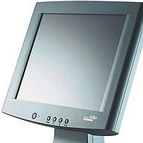

In [6]:
img = PIL.Image.fromarray(img_patches(num_patch_example,False), 'RGB')
img

# Starting CAFFE

In [ ]:
sys.path.insert(0, CAFFE_ROOT + 'python/')
import caffe
from caffe import layers as L, params as P
#caffe.set_mode_cpu()
caffe.set_device(0)
caffe.set_mode_gpu()

### Load a network

In [ ]:
net = caffe.Net(CAFFE_ROOT+'models/bvlc_reference_caffenet/deploy.prototxt',
                CAFFE_ROOT+'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)

net.blobs['data'].reshape(1,3,227,227)

In [ ]:
print('Blobs :')
print([(k, v.data.shape) for k, v in net.blobs.items()])

print('\n')
print('Params :')
print([(k, v[0].data.shape, v[1].data.shape) for k, v in net.params.items()])

print('\n')
print('Inputs :')
print net.inputs

print('\n')
print('Data shape :')
print net.blobs['data'].data.shape

### 1st way : load from file and process with a caffe.io.Transformer

In [ ]:
# load input and configure preprocessing
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', np.load(CAFFE_ROOT+'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

In [ ]:
im = caffe.io.load_image(path_img)
net.blobs['data'].data[...] = transformer.preprocess('data', im)

In [ ]:
#compute
out = net.forward()

In [ ]:
#predicted predicted class
print out['prob'].argmax()
#print predicted labels
labels = np.loadtxt(CAFFE_ROOT+"data/ilsvrc12/synset_words.txt", str, delimiter='\t')
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]

### 2nd way : load from numpy array and apply transformation

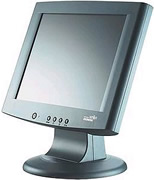

In [7]:
from skimage.transform import resize
img = img_patches.img
img_to_show = PIL.Image.fromarray(img, 'RGB')
img_to_show

In [ ]:
img = resize(img, (227, 227,3),preserve_range=False) # give the shape and convert to float64 (already lies between 0 and 1 because it uses img_as_float)
img_to_show = PIL.Image.fromarray((255*img).astype(np.uint8), 'RGB')
img_to_show

In [ ]:
img = img[:,:,::-1] # convert from RGB (0,1,2) to BGR (2,1,0)
img_to_show = PIL.Image.fromarray((255*img).astype(np.uint8), 'RGB')
img_to_show

In [ ]:
img = img.transpose((2,0,1)) # from HxWxC to CxHxW
img_to_show = PIL.Image.fromarray((255*img).astype(np.uint8), 'RGB')
img_to_show

In [ ]:
net.blobs['data'].data[...] = 255.*img
out = net.forward()
labels = np.loadtxt(CAFFE_ROOT+"data/ilsvrc12/synset_words.txt", str, delimiter='\t')
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print(labels[top_k])

### 3rd way : load from numpy array and apply transformation with pytnn library

In [ ]:
img = img_patches.img
net.blobs['data'].data[...] = pytnn.preprocess(img,227,227,3,255)
out = net.forward()
labels = np.loadtxt(CAFFE_ROOT+"data/ilsvrc12/synset_words.txt", str, delimiter='\t')
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print(labels[top_k])

### Testing batch

In [ ]:
net.blobs['prob'].data.shape

In [ ]:
net.blobs['data'].reshape(10,3,227,227)
for i in range(0,10):
    img = img_patches(i)
    net.blobs['data'].data[i,...] = pytnn.preprocess(img,227,227,3,255)
out = net.forward()
labels = np.loadtxt(CAFFE_ROOT+"data/ilsvrc12/synset_words.txt", str, delimiter='\t')

top_k = np.zeros([10,5])
for i in range(0,10):
    top_k[i,:] = net.blobs['prob'].data[i,:].flatten().argsort()[-1:-6:-1]

In [ ]:
net.blobs['prob'].data[i,:].flatten().argsort()[-1:-6:-1]

In [ ]:
top_k

### Lots of details in :
https://github.com/BVLC/caffe/blob/master/python/caffe/io.py

Tuto available at : http://christopher5106.github.io/deep/learning/2015/09/04/Deep-learning-tutorial-on-Caffe-Technology.html